References: https://www.kaggle.com/ilialar/california-housing-analysis-and-preciction as a refence to this jupyter notebook

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU,Dense
from tensorflow.keras.metrics import RootMeanSquaredError as RMSE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
pd.options.mode.chained_assignment = None 

The only missing values are in the total bedrooms column, we will later address this problem, for now we will just drop them

In [190]:
dataset_path ="Datasets/California Housing/housing.csv"

housing_dataset = pd.read_csv(dataset_path)
housing_dataset_dropped = housing_dataset.dropna()

dataset_train,dataset_test = train_test_split(housing_dataset,test_size=0.25,random_state=1)
print("Values Count {} \t Number of Features {}".format(housing_dataset.shape[0],housing_dataset.shape[1]))


print("Train dataset count : {} values".format(dataset_train.shape[0]))
print("Train dataset count : {} values".format(dataset_test.shape[0]))

print(housing_dataset_dropped.isna().any(axis=0))


Values Count 20640 	 Number of Features 10
Train dataset count : 15480 values
Train dataset count : 5160 values
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool


In [191]:
features = list(housing_dataset.columns)
numerical_features = list(housing_dataset.select_dtypes(np.number).columns)
categorical_features = list(housing_dataset.select_dtypes(np.object).columns)

print("Dataset features: {} ".format(numerical_features))
print("Dataset numerical features: {} ".format(numerical_features))
print("Dataset categorical features: {} ".format(categorical_features))

Dataset features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'] 
Dataset numerical features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'] 
Dataset categorical features: ['ocean_proximity'] 


As we seen in the histogram there are few distribution that are skewed, and there could be some clipped data in the median_house_value and in the housing_median_age.
We can try to normalize the skewed distrubtion to transform them to be more similar of a normal distribution with a logarithm operation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38c80a0908>,
      dtype=object)

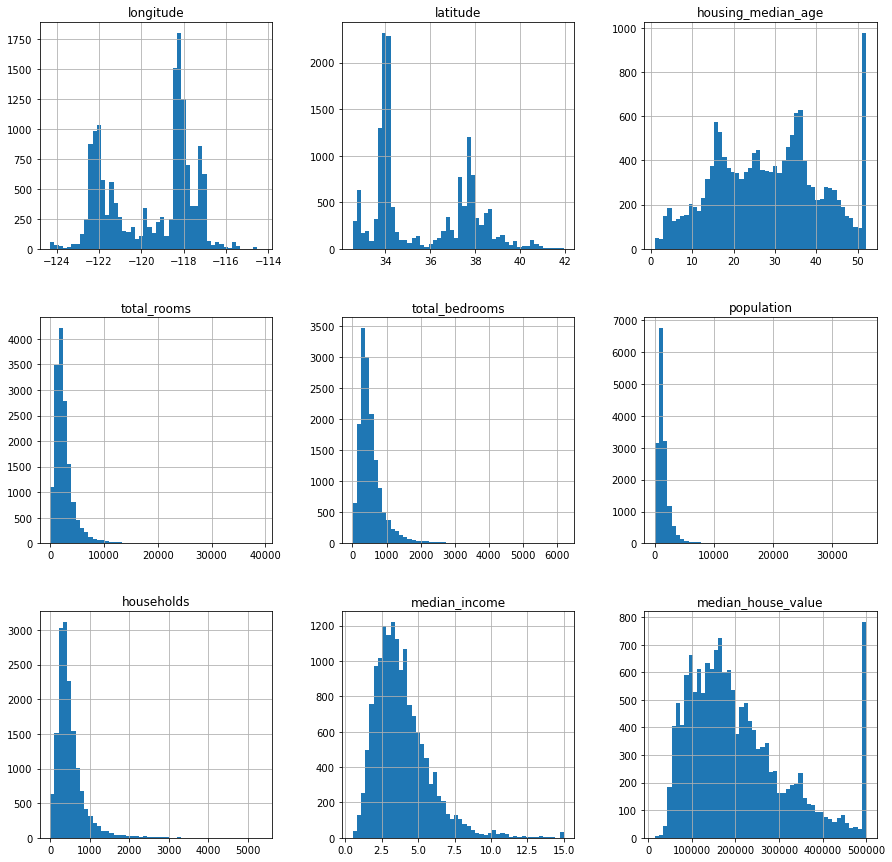

In [192]:
dataset_train[numerical_features].hist(bins=50,figsize=(15,15))

In [193]:
skewed_features = ["total_rooms","total_bedrooms","population","households","median_income","median_house_value"]
log_features = []
for clmn in skewed_features:
    dataset_train[clmn + "_log"] = np.log1p(dataset_train[clmn])
    dataset_test[clmn + "_log"] = np.log1p(dataset_test[clmn])
    log_features.append(clmn+"_log")
print("Features normalized with log : {0}".format(log_features))

Features normalized with log : ['total_rooms_log', 'total_bedrooms_log', 'population_log', 'households_log', 'median_income_log', 'median_house_value_log']


As we seen now the distrubition resemble more a normal distribution so the logarithm worked even if is not perfect we add an column that is the log distribution standardadized so we can see how the different distribution perform during regression

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38c80a0be0>,
      dtype=object)

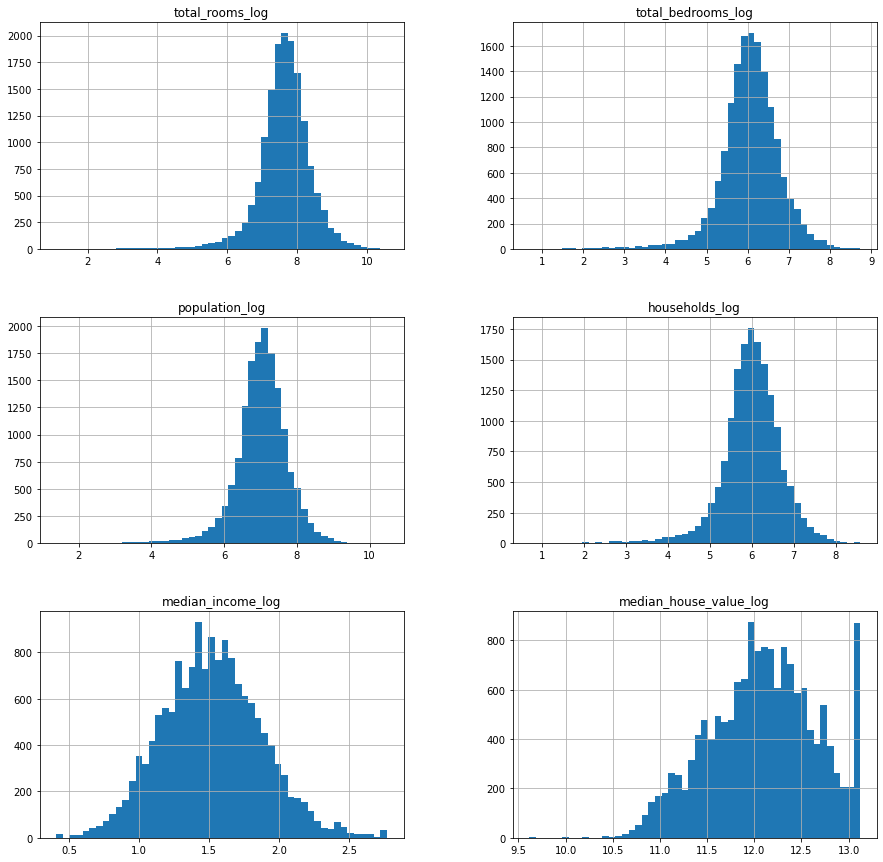

In [194]:
dataset_train[log_features].hist(bins=50,figsize=(15,15))

In [195]:
'''standardized_features = []
for clm in log_features:
    clm_mean = dataset_train[clm].mean()
    clm_std = dataset_train[clm].std()    
    
    dataset_train[clm +"_standard"] = (dataset_train[clm] - clm_mean)/clm_std
    dataset_test[clm +"_standard"] = (dataset_test[clm] - clm_mean)/clm_std
    standardized_features.append(clm+"_standard")
    
print("Standardized Features:{}".format(standardized_features))
'''

'standardized_features = []\nfor clm in log_features:\n    clm_mean = dataset_train[clm].mean()\n    clm_std = dataset_train[clm].std()    \n    \n    dataset_train[clm +"_standard"] = (dataset_train[clm] - clm_mean)/clm_std\n    dataset_test[clm +"_standard"] = (dataset_test[clm] - clm_mean)/clm_std\n    standardized_features.append(clm+"_standard")\n    \nprint("Standardized Features:{}".format(standardized_features))\n'

In [196]:
#dataset_train[standardized_features].hist(bins=50,figsize=(15,15))

Let's check if there are clipped data and if there is clipped data just create a new column to set a boolean at true if we think that the value are clipped.First we standardize the distribution and then we check if the max % check within the % of the std

In [197]:

max_median_value = dataset_train["median_house_value"].max()
min_median_value = dataset_train["median_house_value"].min()

count_max_median_value = np.sum(dataset_train["median_house_value"] == max_median_value)
count_min_median_value = np.sum(dataset_train["median_house_value"] == min_median_value)


print("Median_House_Value: ")
print("\t# of value clipped to Max {} \t % of value clipped to Max {}%".format(count_max_median_value,100*count_max_median_value/dataset_train["median_house_value"].count())) 
print("\t# of value clipped to min {} \t % of value clipped to min {}%".format(count_min_median_value,100*count_min_median_value/dataset_train["median_house_value"].count())) 


max_median_age = dataset_train["housing_median_age"].max()
min_median_age = dataset_train["housing_median_age"].min()

count_max_median_age = np.sum(dataset_train["housing_median_age"] == max_median_age)
count_min_median_age = np.sum(dataset_train["housing_median_age"] == min_median_age)

print("Housing_median_age: ")
print("\t# of value clipped to Max {} \t % of value clipped to Max {}%".format(count_max_median_age,100*count_max_median_age/dataset_train["housing_median_age"].count())) 
print("\t# of value clipped to min {} \t % of value clipped to min {}%".format(count_min_median_age,100*count_min_median_age/dataset_train["housing_median_age"].count())) 




Median_House_Value: 
	# of value clipped to Max 734 	 % of value clipped to Max 4.741602067183463%
	# of value clipped to min 3 	 % of value clipped to min 0.01937984496124031%
Housing_median_age: 
	# of value clipped to Max 941 	 % of value clipped to Max 6.078811369509044%
	# of value clipped to min 4 	 % of value clipped to min 0.025839793281653745%


Probably the max value and age are probably clipped so we add a column to each of them and we set a boolean to true if the variable are equal to the max

In [198]:
features_to_clip = ["median_house_value","housing_median_age"]
clipped_features = []
for clmn in features_to_clip:
    dataset_train[clmn + "_clipped"] = (dataset_train[clmn] == dataset_train[clmn].max())
    dataset_test[clmn + "_clipped"] = (dataset_test[clmn] == dataset_test[clmn].max())
    clipped_features.append(clmn + "_clipped")
    
print("Clipped Features: {}".format(clipped_features))

Clipped Features: ['median_house_value_clipped', 'housing_median_age_clipped']


In [199]:
dataset_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_rooms_log,total_bedrooms_log,population_log,households_log,median_income_log,median_house_value_log,median_house_value_clipped,housing_median_age_clipped
13053,-121.30,38.60,32.0,9534.0,1819.0,4951.0,1710.0,3.3926,103400.0,INLAND,9.162725,7.506592,8.507547,7.444833,1.479921,11.546370,False,False
2653,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN,7.704361,5.978886,6.811244,5.913503,1.211078,11.620892,False,True
3078,-118.92,35.47,6.0,1755.0,280.0,664.0,254.0,6.2885,216400.0,INLAND,7.470794,5.638355,6.499787,5.541264,1.986298,12.284888,False,False
3655,-118.43,34.22,36.0,1372.0,295.0,774.0,306.0,3.6618,187300.0,<1H OCEAN,7.224753,5.690359,6.652863,5.726848,1.539402,12.140472,False,False
4974,-118.28,34.00,42.0,855.0,284.0,890.0,247.0,1.2778,112500.0,<1H OCEAN,6.752270,5.652489,6.792344,5.513429,0.823210,11.630717,False,False


Let's check an heatmap to view if some of the features are high correlated and we can reduce the dimensionality of our dataset

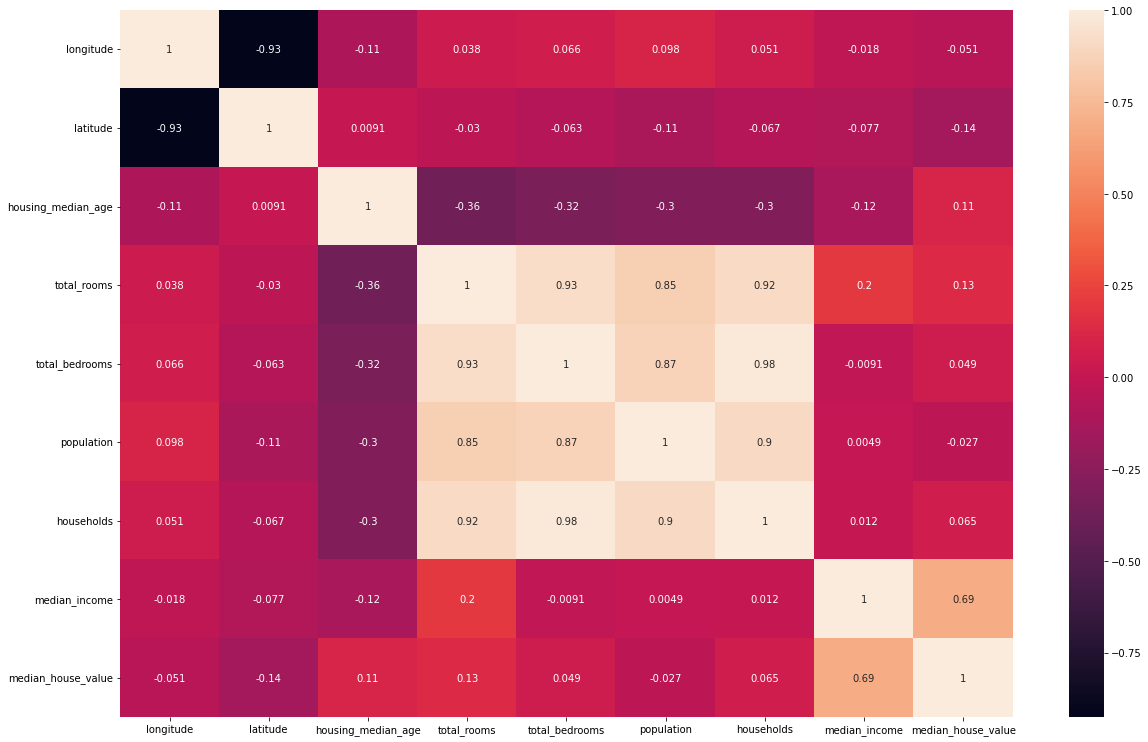

In [200]:
corr_map = dataset_train[numerical_features].corr()
plt.rcParams["figure.figsize"] =(20,13)
sns.heatmap(corr_map,annot=True)




There are 4 feature that are higly correlated one of them is the total_bedrooms feature, the one that have nan value so we can try to address the nan value problem with an prediction with an linear model, and we can confront this method with just setting the nan to the avg value.

In [201]:

column_features_to_drop = ["median_house_value","ocean_proximity","median_house_value_log","total_bedrooms_log"]
column_features_to_drop_log = ["median_house_value","total_bedrooms","median_house_value_log","ocean_proximity"]

train_dt_bedrooms = dataset_train.drop(column_features_to_drop, axis=1)
train_dt_bedrooms = train_dt_bedrooms[~ pd.isnull(train_dt_bedrooms).any(axis=1)]

train_dt_bedrooms_log = dataset_train.drop(column_features_to_drop_log ,axis=1)
train_dt_bedrooms_log = train_dt_bedrooms_log[~ pd.isnull(train_dt_bedrooms_log).any(axis=1)]

train_bedrooms,test_bedrooms = train_test_split(train_dt_bedrooms,test_size=0.1)
train_bedrooms_log,test_bedrooms_log = train_test_split(train_dt_bedrooms_log,test_size=0.1)



test_bedrooms = test_bedrooms.astype(np.float32)
x_dataset = train_bedrooms.drop(['total_bedrooms'],axis=1).astype(np.float32)
y_dataset = train_bedrooms["total_bedrooms"]

test_bedrooms_log = test_bedrooms_log.astype(np.float32)
x_dataset_log = train_bedrooms_log.drop(['total_bedrooms_log'],axis=1).astype(np.float32)
y_dataset_log = train_bedrooms_log["total_bedrooms_log"]

linear_model = Sequential([
    Dense(10,kernel_initializer=keras.initializers.HeNormal(),input_shape=(x_dataset.shape[1],)),
    ReLU(),
    Dense(3,kernel_initializer=keras.initializers.HeNormal()),
    ReLU(),
    Dense(1)
])

linear_model.compile(loss='mean_squared_error')
linear_model.fit(x_dataset,y_dataset,epochs=40)


linear_model_log = Sequential([
    Dense(10,kernel_initializer=keras.initializers.HeNormal(),input_shape=(x_dataset_log.shape[1],)),
    ReLU(),
    Dense(3,kernel_initializer=keras.initializers.HeNormal()),
    ReLU(),
    Dense(1)
])

linear_model_log.compile(loss='mean_squared_error')
linear_model_log.fit(x_dataset_log,y_dataset_log,epochs=30)

Epoch 1/40
432/432 [==============================] - 1s 1ms/step - loss: 36219.3945
Epoch 2/40
432/432 [==============================] - 1s 1ms/step - loss: 15297.8408
Epoch 3/40
432/432 [==============================] - 1s 1ms/step - loss: 11792.1621
Epoch 4/40
432/432 [==============================] - 1s 2ms/step - loss: 9138.6855
Epoch 5/40
432/432 [==============================] - 1s 2ms/step - loss: 7044.0215
Epoch 6/40
432/432 [==============================] - 1s 1ms/step - loss: 6217.3071
Epoch 7/40
432/432 [==============================] - 1s 1ms/step - loss: 6007.1304
Epoch 8/40
432/432 [==============================] - 1s 1ms/step - loss: 5890.1802
Epoch 9/40
432/432 [==============================] - 1s 1ms/step - loss: 5744.5273
Epoch 10/40
432/432 [==============================] - 0s 1ms/step - loss: 5751.4033
Epoch 11/40
432/432 [==============================] - 1s 1ms/step - loss: 5744.8159
Epoch 12/40
432/432 [==============================] - 1s 1ms/step - lo

In [202]:

def RMSE(obs,pred):
    rmse = np.sqrt(mean_squared_error(obs,pred))
    #print(rmse,obs.mean())
    return rmse


print("Total")
print(RMSE(test_bedrooms['total_bedrooms'], linear_model.predict(test_bedrooms.drop(['total_bedrooms'],axis=1))))


print("Log")
print(RMSE(test_bedrooms_log['total_bedrooms_log'], linear_model_log.predict(test_bedrooms_log.drop(['total_bedrooms_log'],axis=1)) ) )


print("Mean: ")
print(RMSE(np.ones(len(test_bedrooms['total_bedrooms']))*test_bedrooms['total_bedrooms'].mean(),test_bedrooms['total_bedrooms']))


print("Mean Log: ")
print(RMSE(np.ones(len(test_bedrooms_log['total_bedrooms_log']))*test_bedrooms_log['total_bedrooms_log'].mean(),
                           test_bedrooms_log['total_bedrooms_log']))


Total
53.6436
Log
0.7045973
Mean: 
413.59040517232694
Mean Log: 
0.7045673520249794


Let's just use the linear model to predict the normal value

In [203]:
dataset_train_to_predict = dataset_train[pd.isnull(dataset_train).any(axis=1)]
predicted_value = linear_model.predict(dataset_train_to_predict.drop(column_features_to_drop + ["total_bedrooms"],axis=1).astype(np.float32) )

dataset_train.loc[pd.isnull(dataset_train).any(axis=1),"total_bedrooms"] = predicted_value

for clmn in skewed_features:
    dataset_train[clmn + "_log"] = np.log1p(dataset_train[clmn])
    dataset_test[clmn + "_log"] = np.log1p(dataset_test[clmn])

print( dataset_train[pd.isnull(dataset_train).any(axis=1)] ) 

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity, total_rooms_log, total_bedrooms_log, population_log, households_log, median_income_log, median_house_value_log, median_house_value_clipped, housing_median_age_clipped]
Index: []


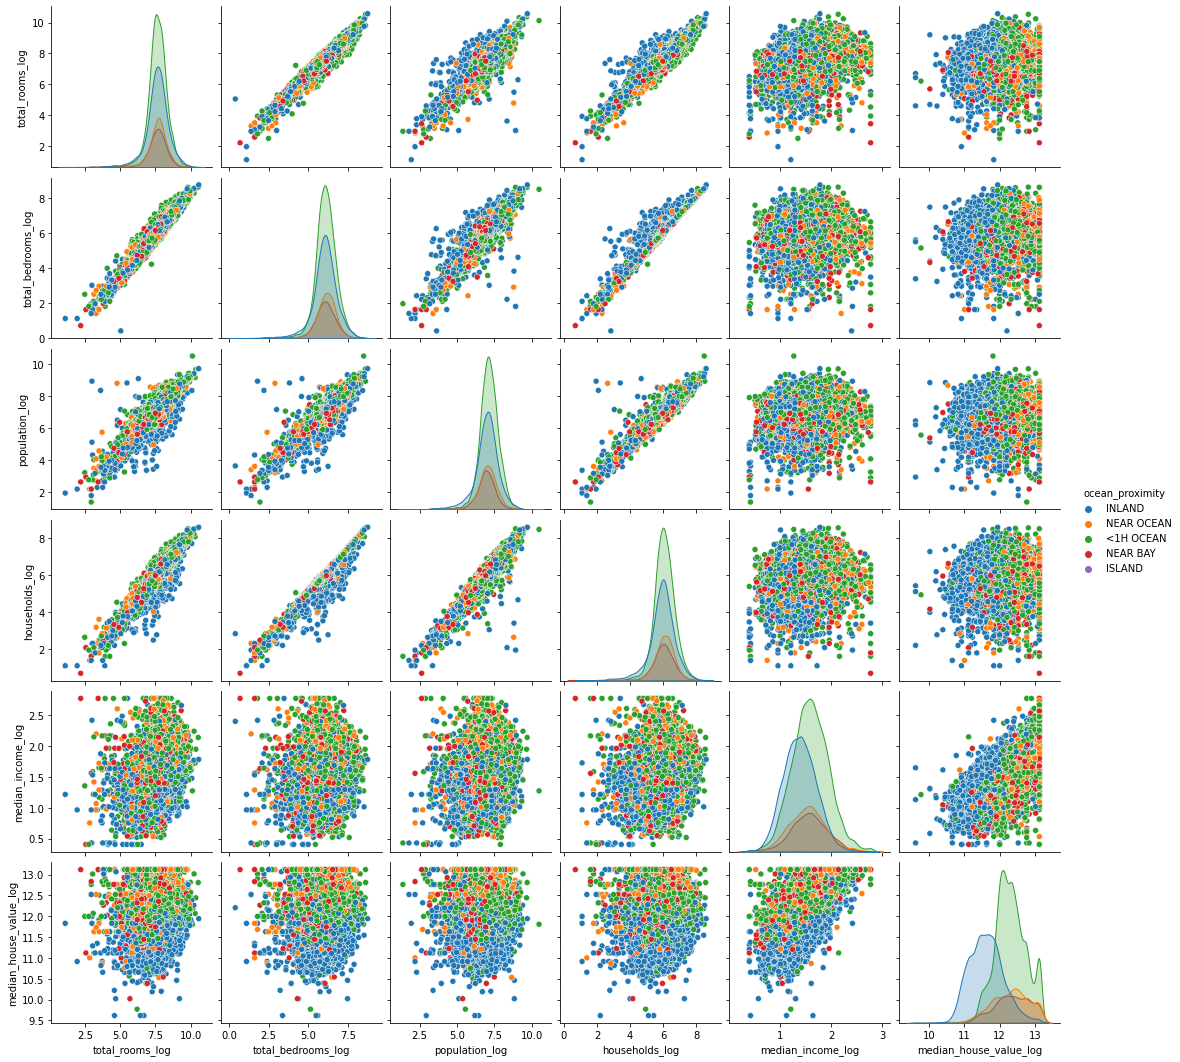

In [204]:
sns.pairplot(dataset_train[log_features+categorical_features],hue="ocean_proximity")

Let's visualize the coordinate and see if we can extrapolate something from it. As we can a lot of the more pricey blocks are around 

/home/edoardo/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


<Figure size 1080x1080 with 0 Axes>

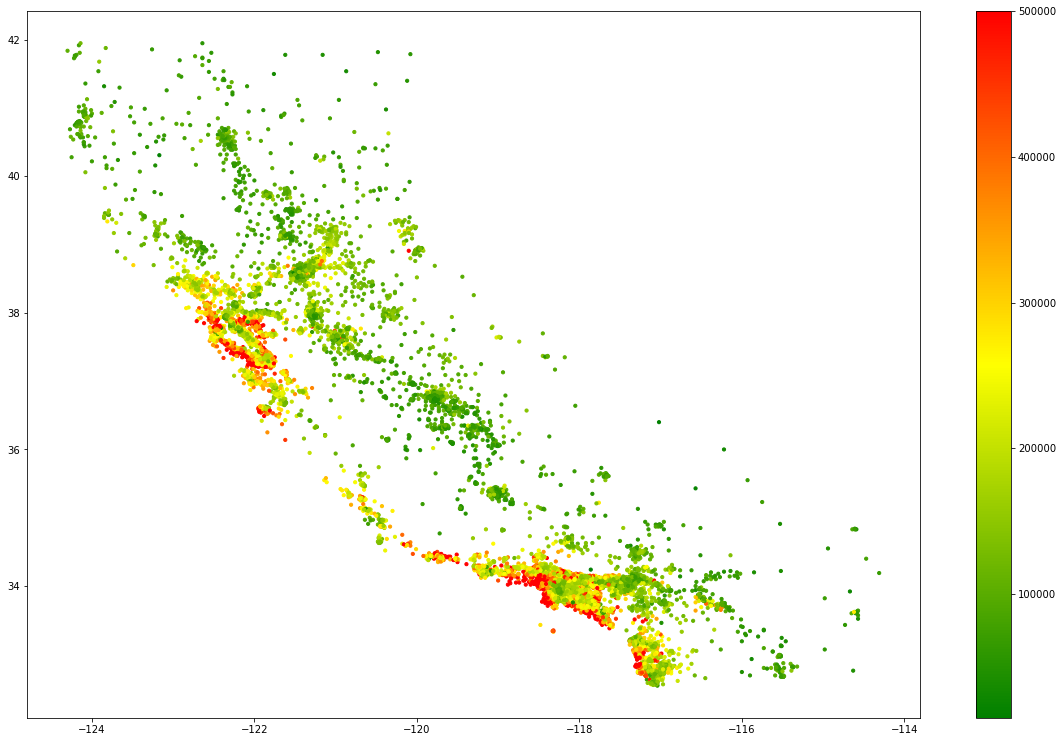

In [205]:
from matplotlib.colors import LinearSegmentedColormap
#import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])

f, ax = plt.subplots()

#img = mpimg.imread("Datasets/California Housing/california_map.jpg")
#ax.imshow(img,extent=[-120,-114,30,42])
points = ax.scatter(dataset_train["longitude"],dataset_train["latitude"],c=dataset_train["median_house_value"],cmap=cmap
          ,s=10,)

f.colorbar(points)
f.show()

/home/edoardo/anaconda3/envs/ml/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


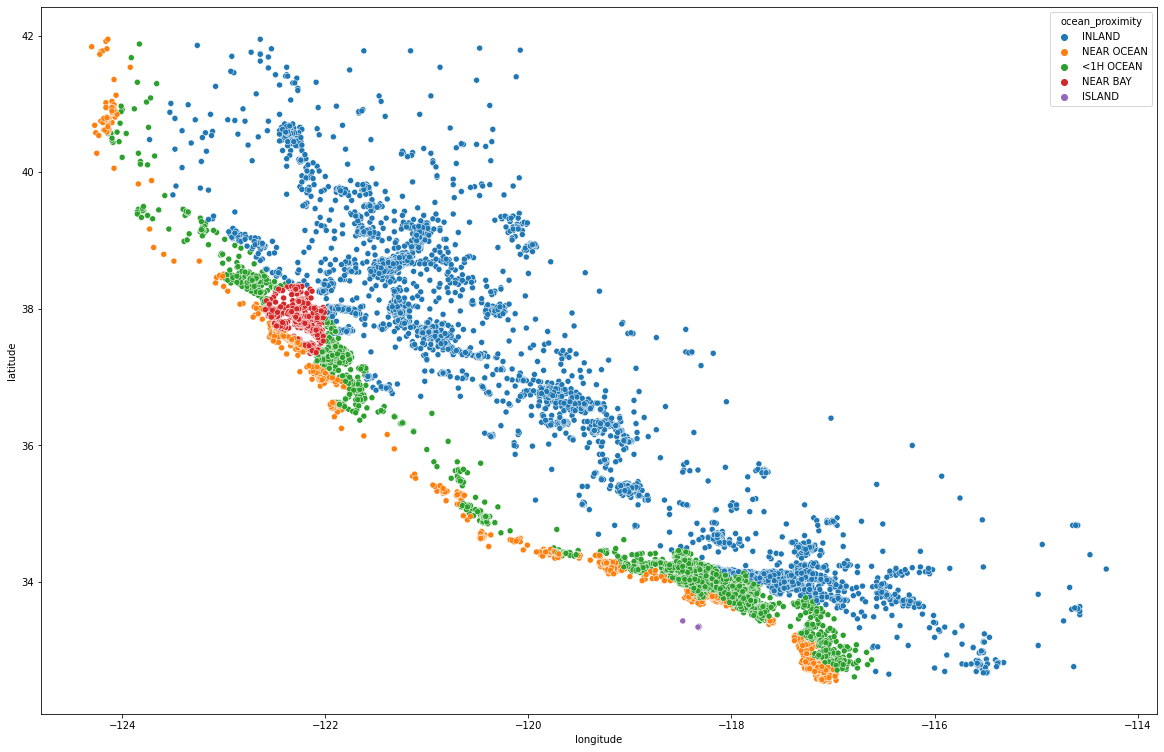

In [206]:
sns.scatterplot(dataset_train['longitude'],dataset_train['latitude'],hue=dataset_train['ocean_proximity'])

/home/edoardo/anaconda3/envs/ml/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


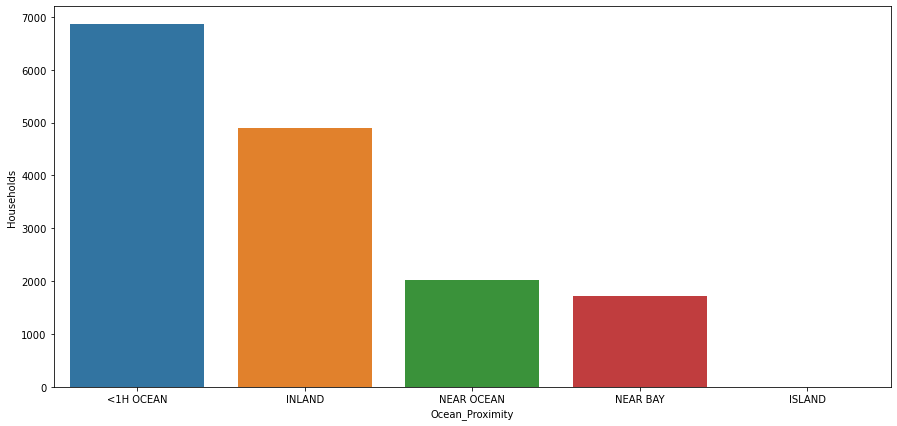

In [207]:
plt.figure(figsize=(15,7))

plt.xlabel("Ocean_Proximity")
plt.ylabel("Households")
ocean_proximity_count = dataset_train['ocean_proximity'].value_counts()
sns.barplot(ocean_proximity_count.index,ocean_proximity_count.values)


Let's encode the ocean proximity as one hot encoder

In [208]:
ocean_proximity_dummies = pd.get_dummies(pd.concat([dataset_train["ocean_proximity"],dataset_test["ocean_proximity"]]),
                                         drop_first=True)

dummies_name = list(ocean_proximity_dummies)

dataset_train = pd.concat([dataset_train,ocean_proximity_dummies[:dataset_train.shape[0]]],axis=1)
dataset_test = pd.concat([dataset_test,ocean_proximity_dummies[dataset_train.shape[0]:]],axis=1)

dataset_train = dataset_train.drop(["ocean_proximity"], axis=1)
dataset_test = dataset_test.drop(["ocean_proximity"], axis=1)



Let's preprocess the data to start data

In [209]:
from sklearn.preprocessing import StandardScaler


'''
def standardize(df):
    standard_dataset = df
    
    for column in df.columns:
        x_mean = df[column].mean()
        x_std = df[column].std()
        
        standard_dataset[column] = (df[column] - x_mean)/x_std
    
    return standard_dataset
'''

standard_scaler = StandardScaler()
scaled_dataset_train = dataset_train
scaled_dataset_test = dataset_test

column_to_standardize= numerical_features+ log_features

column_to_standardize.remove("median_house_value")
column_to_standardize.remove("median_house_value_log")

scaled_dataset_train[column_to_standardize] = standard_scaler.fit_transform(dataset_train[column_to_standardize])
scaled_dataset_test[column_to_standardize] = standard_scaler.transform(dataset_test[column_to_standardize])

#dataset_train[column_to_standardize] = standardize(dataset_train[column_to_standardize])

print(scaled_dataset_test)
    

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4712    0.605851 -0.736446            0.827120     0.079555        0.314333   
2151   -0.101152  0.535549            0.668251    -0.209174       -0.198573   
15927  -1.415580  0.979812            1.383162    -0.378254       -0.303540   
82     -1.345876  1.017224            1.859770    -1.061502       -1.052622   
8161    0.720366 -0.848681            0.668251    -0.511762       -0.592199   
...          ...       ...                 ...          ...             ...   
20073  -0.399886  1.092047            1.462597    -0.728886       -0.761578   
16471  -0.833050  1.166870           -0.284964    -0.615704       -0.639911   
3050    0.117919 -0.016272           -0.999875    -0.486816       -0.546873   
8003    0.715387 -0.829975            0.588817    -0.431842       -0.508703   
20074  -0.340139  1.166870           -0.920441    -1.079518       -1.059779   

       population  households  median_income  media

Let's try some model

In [220]:
scaled_dataset_train = scaled_dataset_train.astype(np.float32)
scaled_dataset_test = scaled_dataset_test.astype(np.float32)

x_train = scaled_dataset_train.drop(["median_house_value","median_house_value_log"],axis=1)
y_train = scaled_dataset_train["median_house_value"]



In [221]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits = 10,random_state =42,shuffle=True)

In [212]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression

svr = svm.SVR()

cv_score_svr = cross_val_score(svr,x_train,y_train,cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.sqrt(-cv_score_svr.mean()))




118429.25585035777


In [213]:
from sklearn.linear_model import Ridge

logistic_model = Ridge()
cv_score_model = cross_val_score(logistic_model,x_train,y_train,cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

print(np.sqrt(-cv_score_model.mean()))


[-3.63520307e+09 -3.65158528e+09 -3.77337344e+09 -3.83259213e+09
 -3.88168806e+09 -3.53804134e+09 -3.53939046e+09 -3.60167706e+09
 -3.61579341e+09 -3.39933466e+09]
60389.302787828245


In [228]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

keras_model = Sequential([
    Dense(50,input_shape=(x_train.shape[1],),kernel_initializer=HeNormal()),
    ReLU(),
    Dense(50,input_shape=(x_train.shape[1],),kernel_initializer=HeNormal()),
    ReLU(),
    Dense(30,input_shape=(x_train.shape[1],),kernel_initializer=HeNormal()),
    ReLU(),
    Dense(20,input_shape=(x_train.shape[1],),kernel_initializer=HeNormal()),
    ReLU(),
    Dense(15,input_shape=(x_train.shape[1],),kernel_initializer=HeNormal()),
    ReLU(),
    Dense(10,kernel_initializer=HeNormal()),
    ReLU(),
    Dense(30,input_shape=(x_train.shape[1],),kernel_initializer=HeNormal()),
    ReLU(),
    Dense(1,kernel_initializer=HeNormal())
])

keras_model.compile(optimizer="rmsprop",loss='mean_squared_error')
scores = keras_model.fit(x_train,y_train,epochs=100,callbacks=[EarlyStopping(patience=10,monitor='loss')])


Epoch 1/100
484/484 [==============================] - 2s 2ms/step - loss: 27414007808.0000
Epoch 2/100
484/484 [==============================] - 1s 2ms/step - loss: 5448514048.0000
Epoch 3/100
484/484 [==============================] - 1s 2ms/step - loss: 4030748928.0000
Epoch 4/100
484/484 [==============================] - 1s 2ms/step - loss: 3542596608.0000
Epoch 5/100
484/484 [==============================] - 1s 2ms/step - loss: 3324647680.0000
Epoch 6/100
484/484 [==============================] - 1s 2ms/step - loss: 3211483136.0000
Epoch 7/100
484/484 [==============================] - 1s 2ms/step - loss: 3133493248.0000
Epoch 8/100
484/484 [==============================] - 1s 2ms/step - loss: 3074982656.0000
Epoch 9/100
484/484 [==============================] - 1s 2ms/step - loss: 3024850688.0000
Epoch 10/100
484/484 [==============================] - 1s 2ms/step - loss: 2979401728.0000
Epoch 11/100
484/484 [==============================] - 1s 2ms/step - loss: 2937284864.0

484/484 [==============================] - 1s 2ms/step - loss: 2131302912.0000
Epoch 91/100
484/484 [==============================] - 1s 2ms/step - loss: 2134624640.0000
Epoch 92/100
484/484 [==============================] - 1s 2ms/step - loss: 2127248000.0000
Epoch 93/100
484/484 [==============================] - 1s 2ms/step - loss: 2123717120.0000
Epoch 94/100
484/484 [==============================] - 1s 2ms/step - loss: 2122477952.0000
Epoch 95/100
484/484 [==============================] - 1s 2ms/step - loss: 2124806656.0000
Epoch 96/100
484/484 [==============================] - 1s 2ms/step - loss: 2112725888.0000
Epoch 97/100
484/484 [==============================] - 1s 2ms/step - loss: 2105312256.0000
Epoch 98/100
484/484 [==============================] - 1s 2ms/step - loss: 2111567104.0000
Epoch 99/100
484/484 [==============================] - 1s 2ms/step - loss: 2103098240.0000
Epoch 100/100
484/484 [==============================] - 1s 2ms/step - loss: 2100473984.0000


In [241]:
x_test = scaled_dataset_test.drop(["median_house_value","median_house_value_log"],axis=1)
y_test = scaled_dataset_test["median_house_value"]

values = keras_model.predict(x_test)
#print(values)
mask = ~np.isnan(values)
values = values[mask]
print(np.sqrt(mean_squared_error( y_test[mask.flatten()] ,values)))

47848.727


Although some values are infinite or too large the rmse calculated on those that are okay is lower than the other model 